In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as op


%matplotlib inline


In [13]:
SeboLMC_raw = pd.read_csv("data/SeboLMC.csv", header = None, names = ["Name","RAh","RAm","RAs","DEd","DEm","DEs","De1V","Period","Bmag","Vmag","Rmag","Imag"])
SeboLMC_raw

,Name,RAh,RAm,RAs,DEd,DEm,DEs,De1V,Period,Bmag,Vmag,Rmag,Imag
0,Evs HV12717,4,43,20.81,-69,13,48.0,0.07,8.84,15.48,14.69,14.20,13.91
1,Evs HV12724,4,46,1.04,-69,38,56.1,0.07,13.74,15.72,14.77,14.21,13.74
2,Evs U1,4,47,6.86,-69,17,39.7,0.07,22.56,15.02,14.09,13.62,13.09
3,Evs HV12447,4,47,24.05,-69,43,19.4,0.13,3.59,16.36,15.84,15.29,15.10
4,Evs HV12452,4,48,51.35,-69,21,22.9,0.06,8.74,15.53,14.77,14.40,13.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,Evs HV12066,5,50,42.89,-69,36,0.8,0.17,3.97,15.99,15.43,15.07,14.75
601,Evs HV6065,5,50,57.05,-69,40,31.2,0.07,6.84,15.93,15.20,14.78,14.40
602,Evs HV12068,5,51,51.46,-69,44,10.7,0.17,2.29,16.46,16.05,15.67,15.44
603,Evs HV12700,5,57,31.45,-67,37,29.4,0.07,8.15,15.68,14.86,14.49,14.11


In [14]:
mask = SeboLMC_raw['Period'] > 0

In [15]:
SeboLMC = SeboLMC_raw[mask]

In [16]:
SeboLMC.shape

(598, 13)

In [106]:
x = np.log10(SeboLMC['Period'])
y = SeboLMC['Vmag']
dy = 0.2

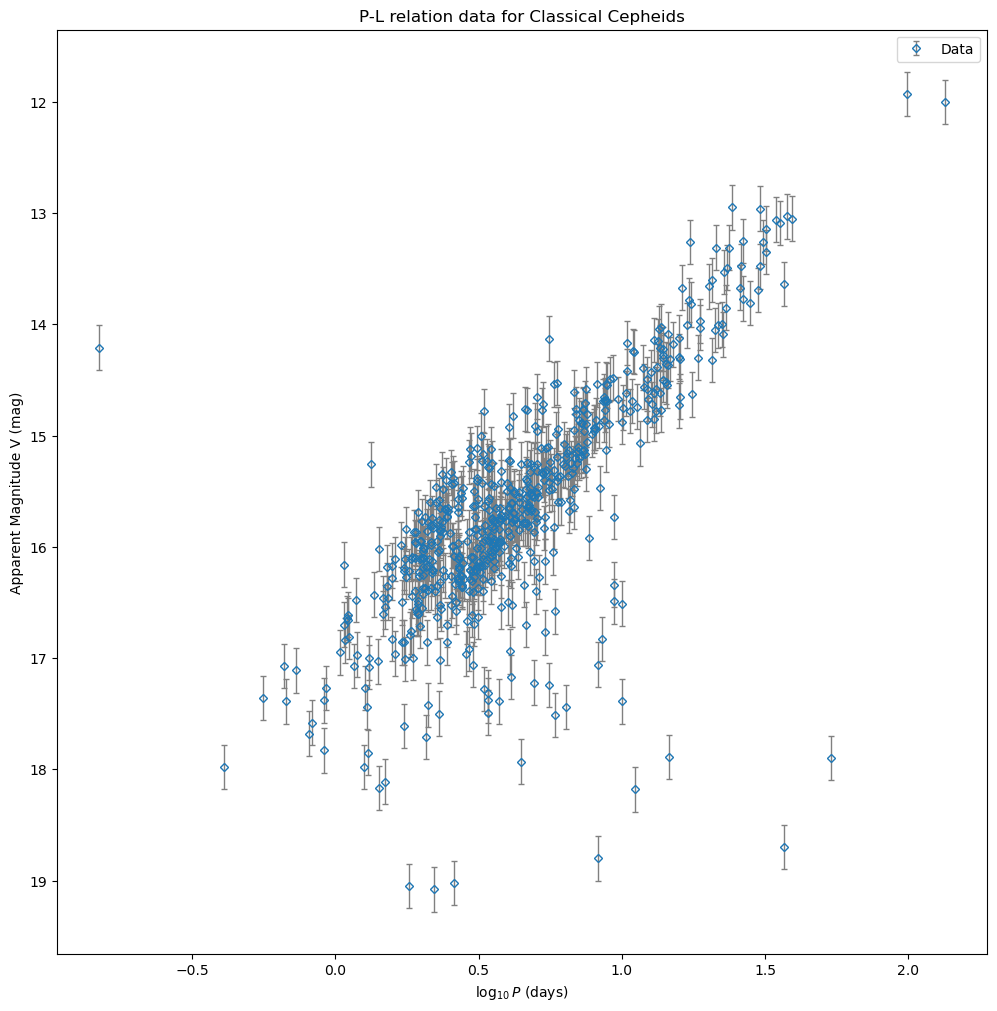

In [109]:
fig = plt.figure()
fig.set_size_inches([12,12])
plt.gca().invert_yaxis()
plt.errorbar(x=x, y=y, yerr=dy, mfc="none", 
            ms=4, fmt="D", ecolor="grey", label="Data",
            elinewidth=1.0, capsize=2)
plt.xlabel(r'$\log_{10}P$ (days)')
plt.ylabel('Apparent Magnitude V (mag)')  
plt.title('P-L relation data for Classical Cepheids')
plt.legend()

Guess for $c_1$ and $c_2$ is -2 and 19.3.

For slope estimate I looked at the points aligining with 0 and 1 on x axis and looking at the y value of the point lying a the middle of those points. At 0, average y value I estimated to be 17 and at 1 it was 15, so I took a difference of 15 and 17. 

For intercept I mentally drawn a line through the points and extended it to the y axis. 19.2 is an approximate value I found this way. 

In [60]:
def polyN(p):
    """
    When called, this function takes a vector of parameters
    and returns another function to evaluate a polynomial
    with these coefficients fixed.
    """
    
    def rfunc(x):
        """
        This function is returned by the polyN function. It takes a
        vector of x values and loops over the order number, generating an Nth order polynomial.
        """
        y = 0
        for i in np.arange(len(p)):
            y += p[i]*x**float(i)
        # Note the indent here
        return y

    # Note the indent here
    return rfunc

In [77]:
def chisq(p, x, y, dy):
    """
    Function to evaluate chi-Squared given parameters and data
    """
    
    # Bake in the current parameters to the polynomial
    evalPolyFunc = polyN(p)

    # Calculate the y values at the given x values
    yModel = evalPolyFunc(x)

    # Calculate chi-squared value
    chisqValue = np.sum( ((yModel - y) / dy)**2 )
    
    return chisqValue

In [50]:
p = np.array([19.3,-2])

In [52]:
print('Chi Squared value is: ', chisq(p,x,y,dy))

Chi Squared value is:  90698.77946009199


In [78]:
retVals = op.fmin(chisq,                        # The function to minimise
                  p,                           # The starting guess
                  args=(x, y, dy),  # The arguments of chisq() after p
                  full_output=1,                # Return warning flags
                  disp=1)                       # Print feedback during iterations

print("The optimiser returned {:d} things".format(len(retVals)))

Optimization terminated successfully.
         Current function value: 7204.242488
         Iterations: 38
         Function evaluations: 74
The optimiser returned 5 things


In [75]:
p_quad = np.append(p, 0)
p_quad

array([19.3, -2. ,  0. ])

In [79]:
retVals_quad = op.fmin(chisq,                        # The function to minimise
                  p_quad,                           # The starting guess
                  args=(x, y, dy),  # The arguments of chisq() after p
                  full_output=1,                # Return warning flags
                  disp=1)                       # Print feedback during iterations

print("The optimiser returned {:d} things".format(len(retVals)))

Optimization terminated successfully.
         Current function value: 7046.987023
         Iterations: 179
         Function evaluations: 315
The optimiser returned 5 things


In [80]:
print(retVals_quad)

(array([16.78690952, -1.36016996, -0.48267479]), 7046.987022696305, 179, 315, 0)


In [144]:
def fit_model(p, x, y):
    xModel = np.linspace(start=np.min(x), 
                         stop=np.max(x), 
                         num=len(x))
    yModel = polyN(p)(xModel)
    
    return xModel,yModel

In [135]:
retVals[0][0]

16.979469796619554

In [145]:
# Access the best-fit polynomial coefficients
pFit = retVals[0]
p2Fit = retVals_quad[0]

x_model_lin, y_model_lin = fit_model(pFit,x,y)
x_model_quad, y_model_quad = fit_model(p2Fit,x,y)

Linear fit parameters:  [16.9794698  -2.06750963] with Chi^2 value 7204.242487873508
Quadratic fit parameters:  [16.78690952 -1.36016996 -0.48267479] with Chi^2 value 7046.987022696305


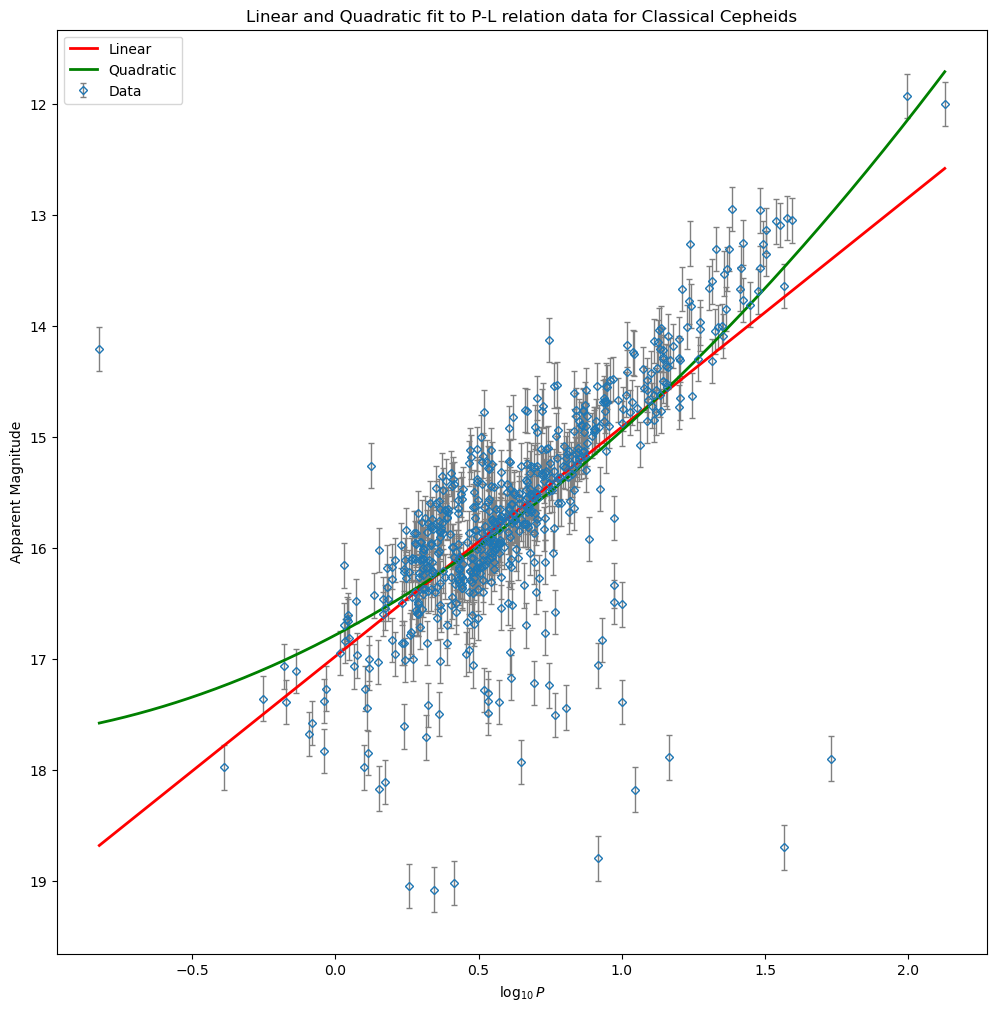

In [146]:
fig = plt.figure()
fig.set_size_inches([12,12])
plt.gca().invert_yaxis()
plt.errorbar(x=x, y=y, yerr=dy, mfc="none", 
            ms=4, fmt="D", ecolor="grey", label="Data",
            elinewidth=1.0, capsize=2)
plt.plot(x_model_lin, y_model_lin, color='red', marker="None", mfc="w",
            mec="g", label='Linear', lw=2.0)
plt.plot(x_model_quad, y_model_quad, color='green', marker="None", mfc="w",
            mec="g", label='Quadratic', lw=2.0)

plt.xlabel(r'$\log_{10}P$')
plt.ylabel('Apparent Magnitude')  
plt.title('Linear and Quadratic fit to P-L relation data for Classical Cepheids')
plt.legend()
print('Linear fit parameters: ', pFit, "with Chi^2 value", retVals[1])
print('Quadratic fit parameters: ', p2Fit, "with Chi^2 value", retVals_quad[1])

In [150]:
res_lin = y - y_model_lin
res_quad = y - y_model_quad

Text(0.5, 1.0, 'Residuas of the Quadratic fit')

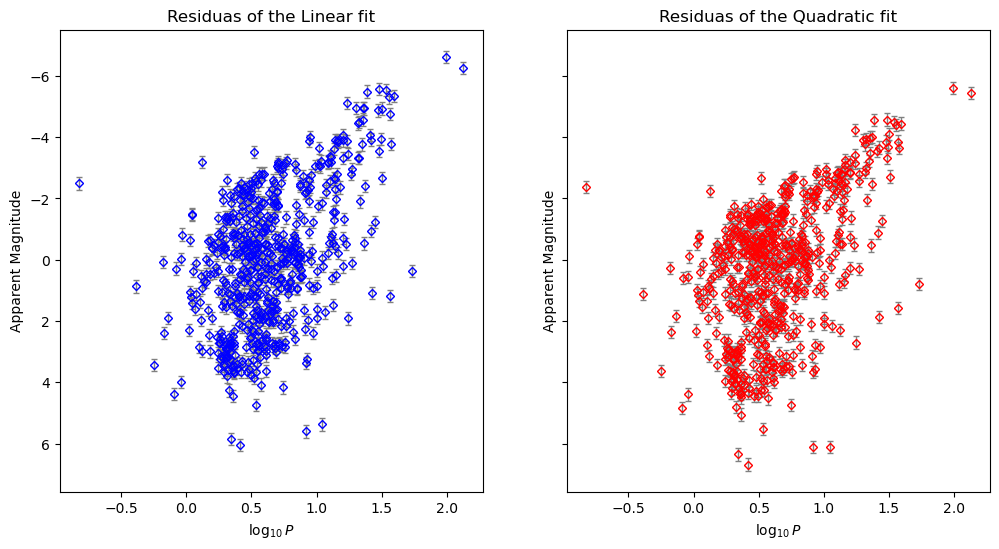

In [163]:
#f = plt.figure()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.gca().invert_yaxis()
f.set_size_inches([12,6])
ax1.errorbar(x=x, y=res_lin, yerr=dy, mfc="none", color = 'blue',
            ms=4, fmt="D", ecolor="grey", label="Residuals of the linear fit",
            elinewidth=1.0, capsize=2)
ax2.errorbar(x=x, y=res_quad, yerr=dy, mfc="none", color = 'red', 
            ms=4, fmt="D", ecolor="grey", label="Residuals of the quadratic fit",
            elinewidth=1.0, capsize=2)


#plt.plot(model_lin[0], model_lin[1], color='red', marker="None", mfc="w",
#            mec="g", label='Linear', lw=2.0)
#plt.plot(model_quad[0], model_quad[1], color='green', marker="None", mfc="w",
#            mec="g", label='Quadratic', lw=2.0)

ax1.set_xlabel(r'$\log_{10}P$')
ax2.set_xlabel(r'$\log_{10}P$')
ax1.set_ylabel('Apparent Magnitude')  
ax2.set_ylabel('Apparent Magnitude')  
ax1.set_title('Residuas of the Linear fit')
ax2.set_title('Residuas of the Quadratic fit')
#f.legend()